In [1]:
import pandas as pd
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, confusion_matrix,roc_auc_score
from lightgbm import LGBMClassifier
from dp_manypets_task_functions import *

In [2]:
policies = pd.read_excel('DataScienceTest_v2.1.xlsx',sheet_name='policies_data')
claims_events = pd.read_excel('DataScienceTest_v2.1.xlsx',sheet_name='claims_events')
claims_payments = pd.read_excel('DataScienceTest_v2.1.xlsx',sheet_name='claims_payments')
churn = pd.read_excel('DataScienceTest_v2.1.xlsx',sheet_name='churn_dataset')

In [3]:
[policies.isnull().sum().sum(),claims_events.isnull().sum().sum(),claims_payments.isnull().sum().sum(),churn.isnull().sum().sum()]

[0, 0, 392, 9]

In [4]:
claims = pd.merge(claims_events,claims_payments,on='claim_id',how='left')
claims[claims['amount_paid'].isnull()].status.value_counts()

Closed         292
In Progress     84
Open            16
Name: status, dtype: int64

In [5]:
claims.status.value_counts()

Approved       4380
Closed          292
Declined        228
In Progress      84
Open             16
Name: status, dtype: int64

There is missing values present on **claims payment** table on all Closed, In Progress and Open status, it seems this is expected behaviour

<AxesSubplot:>

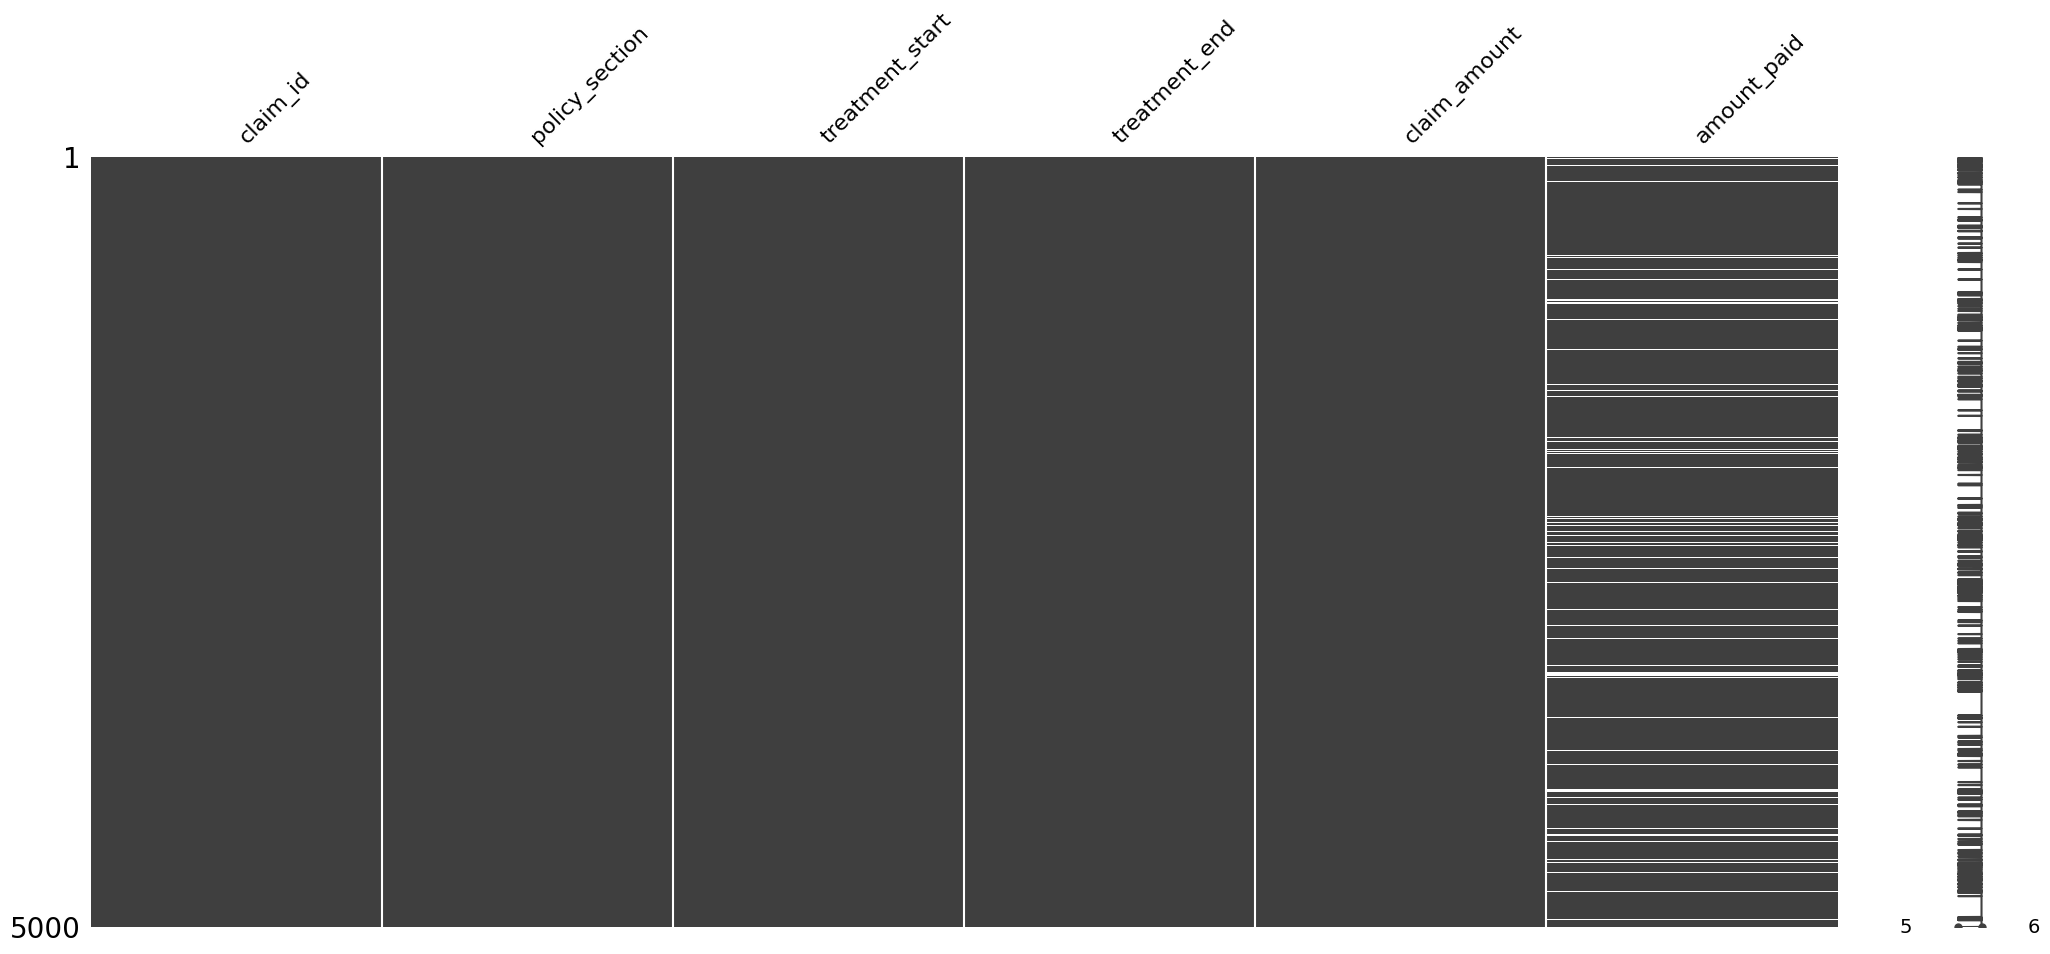

In [6]:
msno.matrix(claims_payments)

<AxesSubplot:>

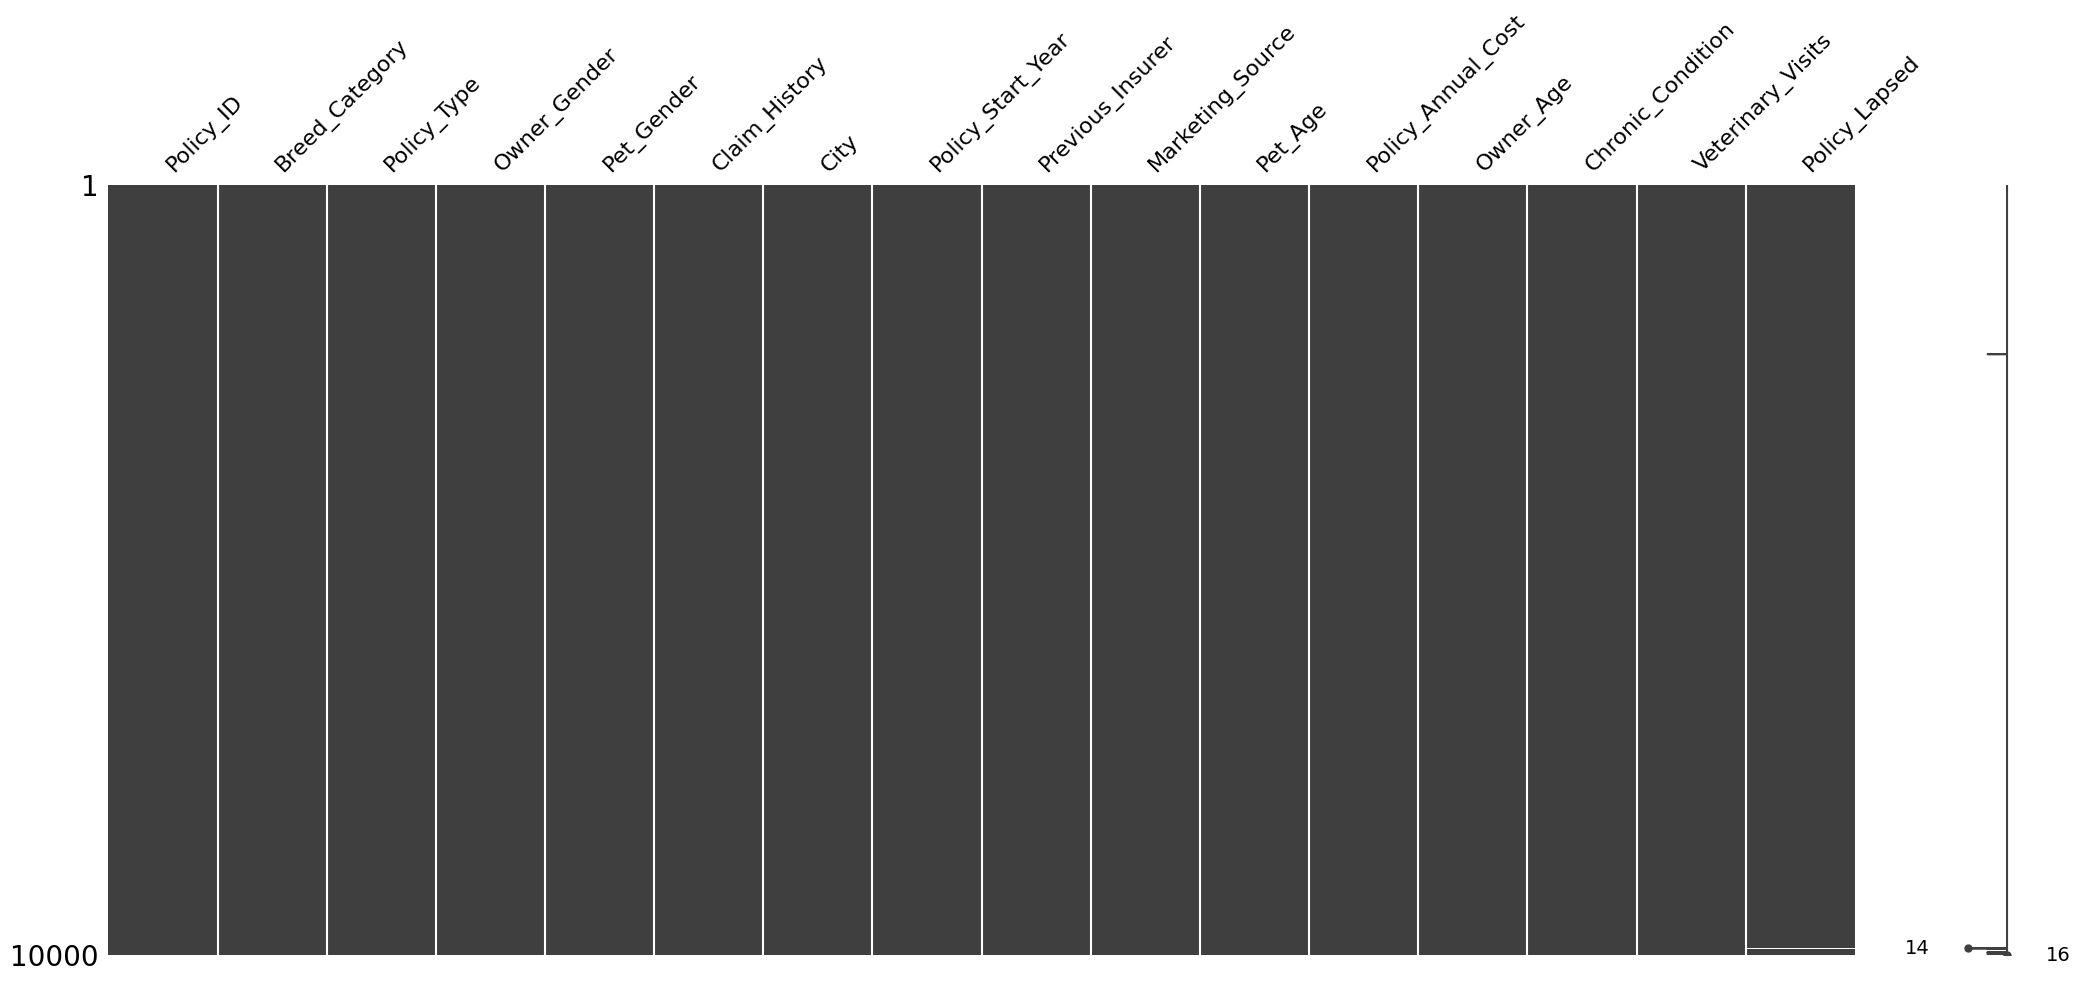

In [7]:
msno.matrix(churn)

#### Part 1 - Question 1

How many policies do we have in the dataset? **3860 policies sold**

How many of them are cats? **809 policies sold for Cats**

How many policies had pets older than 6 when the policy was purchased? **644 policies were sold for pets older than 6 years old**



In [8]:
policies['policy_id'].nunique()

3860

In [9]:
policies.groupby('species').agg({'policy_id':'nunique','premium':'sum'})

,policy_id,premium
species,,
Cat,809,251393.89
Dog,3266,1045252.65


In [10]:
policies[policies['pet_age_at_purchase']>6]['policy_id'].nunique()

644

#### Part 1 - Question 2

In [11]:
policies_claims_combined = pd.merge(policies,claims,on='policy_id')

In [12]:
policies_agg = policies.groupby('policy_id').agg({'pet_id':'count','premium':'sum','species':'nunique','pet_age_at_purchase':'mean'}).reset_index()
policies_agg = policies_agg.rename(columns={'pet_id':'total_pets','premium':'total_premium','pet_age_at_purchase':'avg_pet_age_at_purchase','species':'total_species'})

In [13]:
policies_agg

,policy_id,total_pets,total_premium,total_species,avg_pet_age_at_purchase
0,04800,1,241.25,1,7.0
1,04806,1,787.80,1,11.0
2,04807,1,312.72,1,0.0
3,0480c,1,286.47,1,7.0
4,04811,1,141.40,1,1.0
...,...,...,...,...,...
3855,f4bf8,2,492.98,1,0.0
3856,f4bf9,1,103.16,1,-1.0
3857,f4bfa,1,140.04,1,3.0
3858,f4bfb,2,505.63,1,1.0


In [14]:
claims['claim_paid'] = 1
claims.loc[claims['amount_paid'].isnull(),'claim_paid'] = 0

In [15]:
claims_agg = claims.groupby(['policy_id']).agg(
    frequency=('claim_id','nunique'),
    frequency_paid=('claim_paid','sum'),
    total_claim_amount=('claim_amount','sum'),
    total_amount_paid=('amount_paid','sum'),
    max_pet_gender=('claim_amount',lambda x: claims.loc[x.idxmax(),'pet_gender']),
    max_pet_type=('claim_amount',lambda x: claims.loc[x.idxmax(),'pet_type'])
).reset_index()

In [16]:
claims_agg

,policy_id,frequency,frequency_paid,total_claim_amount,total_amount_paid,max_pet_gender,max_pet_type
0,04801,1,1,542.15,542.15,Female,Dog
1,04807,1,0,173.26,0.00,Male,Cat
2,04808,1,1,1102.23,1102.23,Male,Dog
3,04809,1,1,1303.15,1303.15,Female,Dog
4,0480a,1,1,307.23,0.00,Male,Dog
...,...,...,...,...,...,...,...
4208,f4bf0,1,1,684.11,684.11,Female,Cat
4209,f4bf1,1,1,925.14,925.14,Male,Dog
4210,f4bf2,2,1,403.48,195.17,Male,Dog
4211,f4bf3,1,1,196.18,196.18,Female,Dog


In [17]:
policies_claims_combined = pd.merge(policies_agg,claims_agg,on='policy_id',how='left')

In [18]:
def loss_ratio(table=policies_claims_combined,groupby=None):
    # Loss Ratio function
    if groupby is None:
        result = table.total_amount_paid.sum()/table.total_premium.sum()
    else:
        result = table.groupby(groupby)['total_amount_paid'].sum()/table.groupby(groupby)['total_premium'].sum()
    return result

loss_ratio()

0.5974715746359065

Text(0.5, 1.0, 'ManyPets LossRatio by Number of pets in policy')

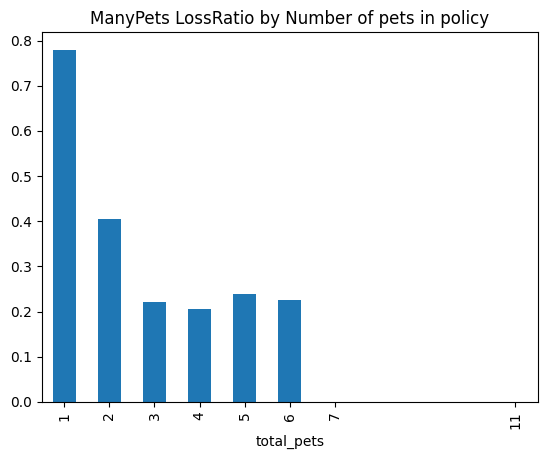

In [19]:
loss_ratio(groupby='total_pets').plot(kind='bar')
plt.title('ManyPets LossRatio by Number of pets in policy')

Text(0.5, 1.0, 'ManyPets LossRatio by Number of spcecies in policy')

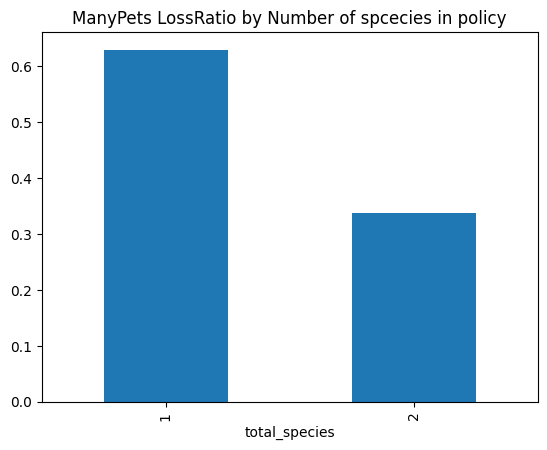

In [20]:
loss_ratio(groupby='total_species').plot(kind='bar')
plt.title('ManyPets LossRatio by Number of spcecies in policy')

In [21]:
policies_claims_combined['age_bins'] = pd.cut(policies_claims_combined['avg_pet_age_at_purchase'],bins=[-3,0,5,15,20],labels=['Before Birth','Puppy/Kitten','Adult','Elder'])

Text(0.5, 1.0, 'Manypets, LossRatio by age groups')

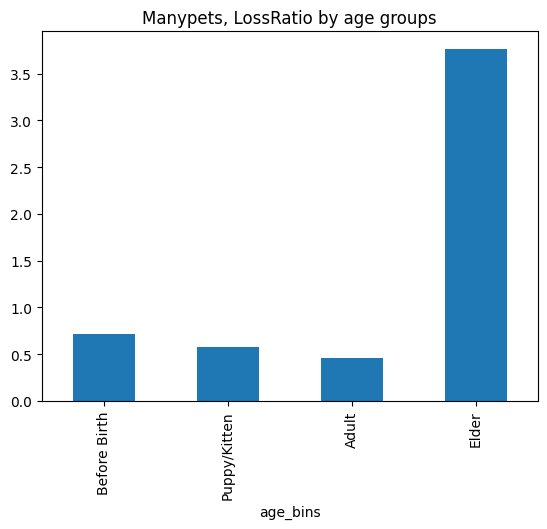

In [22]:
loss_ratio(table=policies_claims_combined,groupby='age_bins').plot(kind='bar')
plt.title('Manypets, LossRatio by age groups')


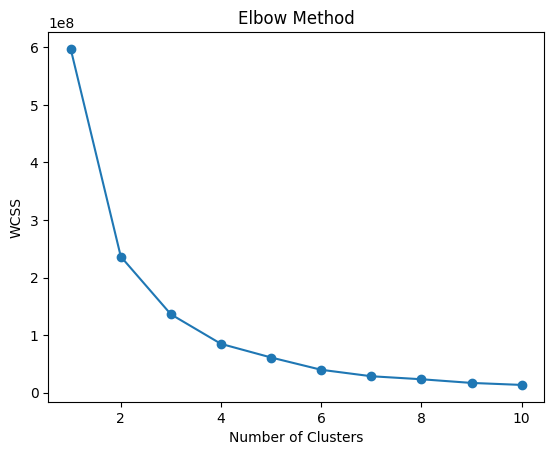

In [23]:
elbow_method(policies_claims_combined[['total_premium']])

In [24]:
kmeans = KMeans(n_clusters=3, random_state=42)
policies_claims_combined['cluster'] = kmeans.fit_predict(policies_claims_combined[['total_premium']])
policies_claims_combined.groupby('cluster')['total_premium'].mean()

cluster
0     153.869376
1    1571.606667
2     626.432700
Name: total_premium, dtype: float64

Text(0.5, 1.0, 'Manypets, Loss Ratio by Premium Clusters')

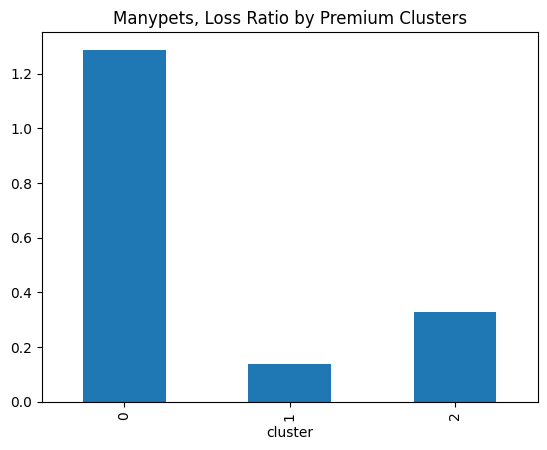

In [25]:
loss_ratio(groupby='cluster').plot(kind='bar')
plt.title('Manypets, Loss Ratio by Premium Clusters')

In [26]:
policies_claims_combined.groupby('cluster')['policy_id'].nunique()

cluster
0    2757
1     192
2     911
Name: policy_id, dtype: int64

#### Part 1 - Question 3

We measure time to claim as the number of days between the policy inception date and the
very first claim. What is the average time to make a claim for cats and dogs? Are these times,
significantly different?

In [27]:
ttc = claims.groupby(['policy_id','policy_inception_date','pet_type']).agg(
                                first_claim_at=('claim_received','min')
).reset_index()

ttc['time_to_claim'] = (ttc['first_claim_at'] - ttc['policy_inception_date']).dt.days

Text(0.5, 1.0, 'Manypets, AVG time to claim (days) Cats vs Dogs')

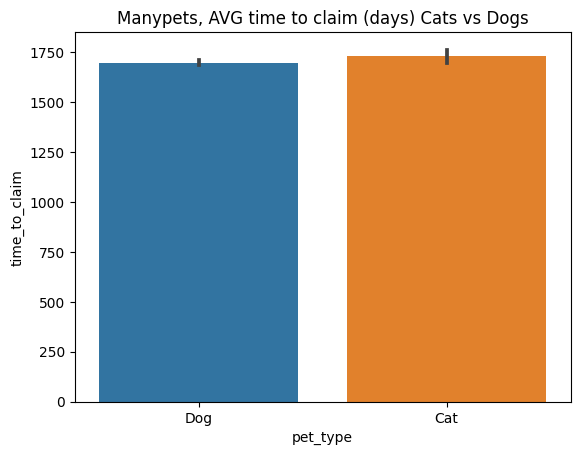

In [28]:
sns.barplot(data=ttc,x="pet_type",y="time_to_claim")
plt.title('Manypets, AVG time to claim (days) Cats vs Dogs')

In [29]:
Cats = ttc[ttc['pet_type']=='Cat']['time_to_claim']
Dogs = ttc[ttc['pet_type']=='Dog']['time_to_claim']

Text(0.5, 1.0, 'HDI (95%), Time to claim Cats vs Dogs')

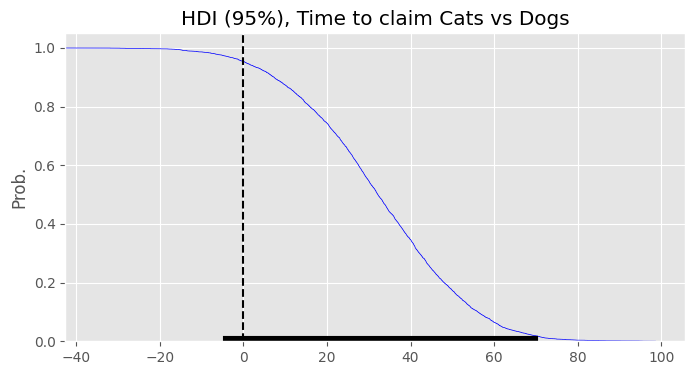

In [30]:
diffs = diff_calculation(Cats,Dogs)
hdi_plot(diffs)
plt.title('HDI (95%), Time to claim Cats vs Dogs')

## Part 2

In [31]:
churn.dtypes

Policy_ID               int64
Breed_Category         object
Policy_Type            object
Owner_Gender           object
Pet_Gender             object
Claim_History           int64
City                   object
Policy_Start_Year       int64
Previous_Insurer       object
Marketing_Source       object
Pet_Age                 int64
Policy_Annual_Cost    float64
Owner_Age               int64
Chronic_Condition       int64
Veterinary_Visits       int64
Policy_Lapsed         float64
dtype: object

In [32]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Policy_ID           10000 non-null  int64  
 1   Breed_Category      9998 non-null   object 
 2   Policy_Type         9998 non-null   object 
 3   Owner_Gender        10000 non-null  object 
 4   Pet_Gender          10000 non-null  object 
 5   Claim_History       10000 non-null  int64  
 6   City                10000 non-null  object 
 7   Policy_Start_Year   10000 non-null  int64  
 8   Previous_Insurer    9999 non-null   object 
 9   Marketing_Source    10000 non-null  object 
 10  Pet_Age             10000 non-null  int64  
 11  Policy_Annual_Cost  9999 non-null   float64
 12  Owner_Age           10000 non-null  int64  
 13  Chronic_Condition   10000 non-null  int64  
 14  Veterinary_Visits   10000 non-null  int64  
 15  Policy_Lapsed       9997 non-null   float64
dtypes: fl

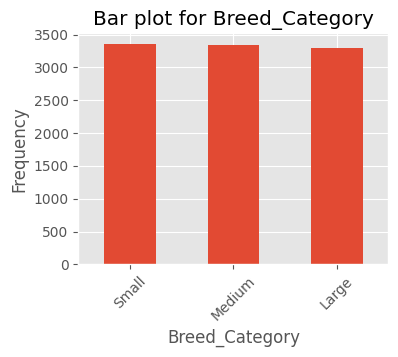

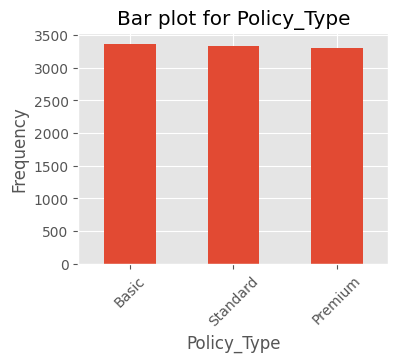

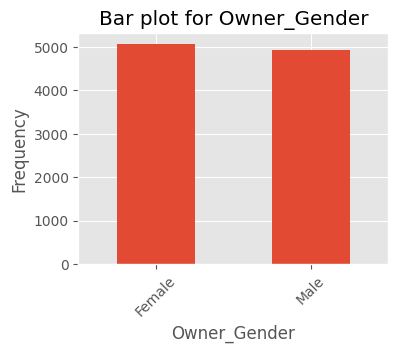

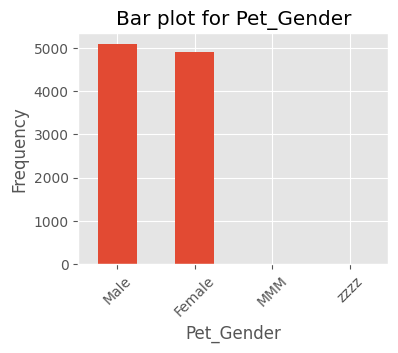

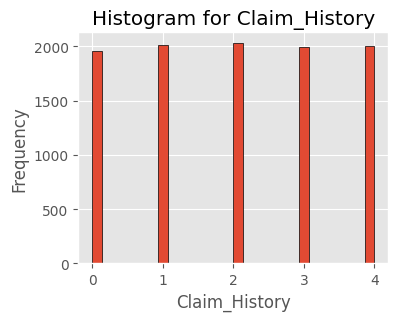

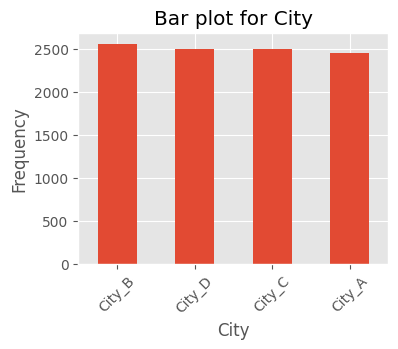

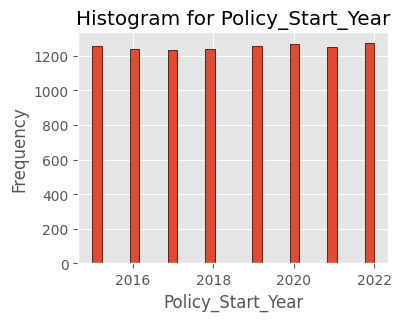

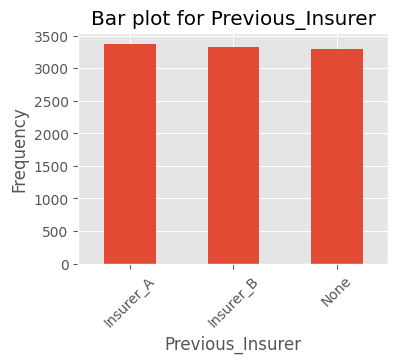

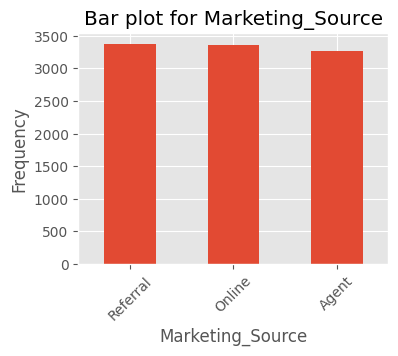

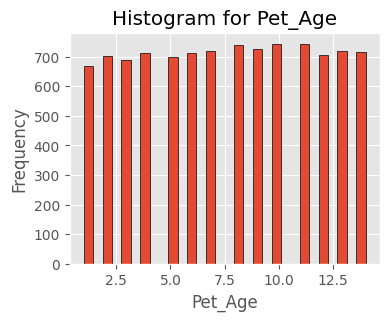

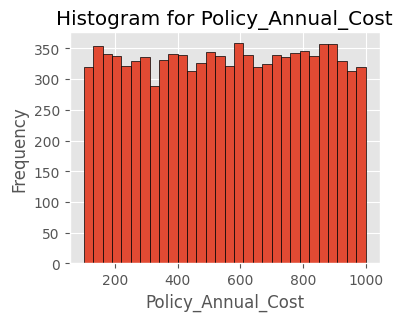

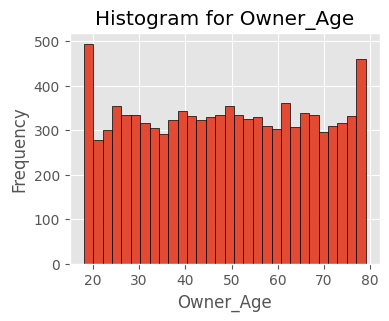

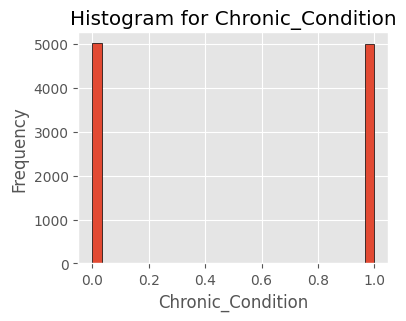

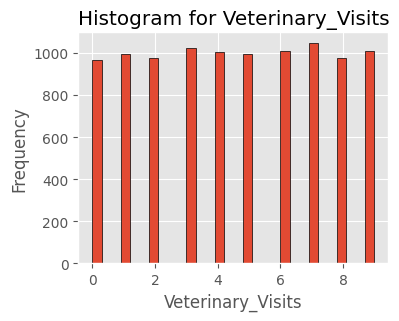

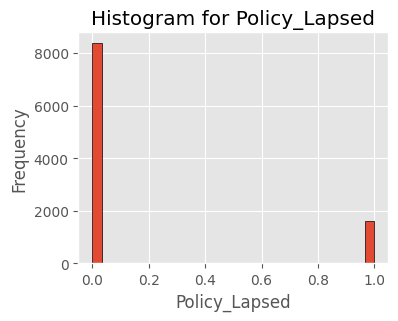

In [33]:
plot_dataframe_summary(churn.drop(columns='Policy_ID'))

In [34]:
churn = churn.dropna() # We drop rows with NA values given is a very small amount
churn = churn[churn['Pet_Gender'].isin(['Male','Female'])] # We also drop inconsistent values

In [35]:
churn.duplicated().value_counts() # No duplicated values

False    9990
dtype: int64

In [36]:
churn.Previous_Insurer.value_counts()

Insurer_A    3375
Insurer_B    3328
None         3287
Name: Previous_Insurer, dtype: int64

In [37]:
churn_encoded = one_hot_encode(churn)
churn_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9990 entries, 0 to 9999
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Policy_ID                   9990 non-null   int64  
 1   Claim_History               9990 non-null   int64  
 2   Policy_Start_Year           9990 non-null   int64  
 3   Pet_Age                     9990 non-null   int64  
 4   Policy_Annual_Cost          9990 non-null   float64
 5   Owner_Age                   9990 non-null   int64  
 6   Chronic_Condition           9990 non-null   int64  
 7   Veterinary_Visits           9990 non-null   int64  
 8   Policy_Lapsed               9990 non-null   float64
 9   Breed_Category_Large        9990 non-null   uint8  
 10  Breed_Category_Medium       9990 non-null   uint8  
 11  Breed_Category_Small        9990 non-null   uint8  
 12  Policy_Type_Basic           9990 non-null   uint8  
 13  Policy_Type_Premium         9990 

In [38]:
X = churn_encoded.drop(columns=['Policy_ID','Policy_Lapsed'])
y = churn_encoded['Policy_Lapsed']
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

In [39]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=12)
mean_accuracy_rf = kfold_cross_validation(X.values, y.values, rf_model, n_splits=5,threshold=0.5)

NameError: name 'roc_auc_score' is not defined

In [132]:
xgb_model = XGBClassifier(eval_metric='mlogloss')
mean_accuracy_xgb = kfold_cross_validation(X, y, xgb_model, n_splits=5,threshold=0.5)

Mean Accuracy: 0.8188188188188189
Mean Precision: 0.7713523064990065
Mean Recall: 0.8188188188188189
Mean F1 Score: 0.7844418423832155
Mean AUC Score: 0.7087081848009784
Mean Log Loss: 0.4605759269742099


In [133]:
svm_model = SVC(probability=True)
mean_accuracy_svm = kfold_cross_validation(X, y, svm_model, n_splits=5,threshold=0.5)

Mean Accuracy: 0.8368368368368367
Mean Precision: 0.7003196389582775
Mean Recall: 0.8368368368368367
Mean F1 Score: 0.7625096745413391
Mean AUC Score: 0.48939704055468736
Mean Log Loss: 0.4458547990777924


In [134]:
from sklearn.ensemble import AdaBoostClassifier
LGBM_model = LGBMClassifier()
mean_accuracy_LGBM = kfold_cross_validation(X, y, LGBM_model, n_splits=5,threshold=0.5)

[LightGBM] [Info] Number of positive: 1318, number of negative: 6674
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 399
[LightGBM] [Info] Number of data points in the train set: 7992, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.164915 -> initscore=-1.622104
[LightGBM] [Info] Start training from score -1.622104
[LightGBM] [Info] Number of positive: 1309, number of negative: 6683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 399
[LightGBM] [Info] Number of data points in the train set: 7992, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.163789 -> initscore=-1.630304
[LightGBM]

### Feature Importance - SHAP

In [152]:
rf_model.fit(X_train,y_train)

RandomForestClassifier(random_state=12)

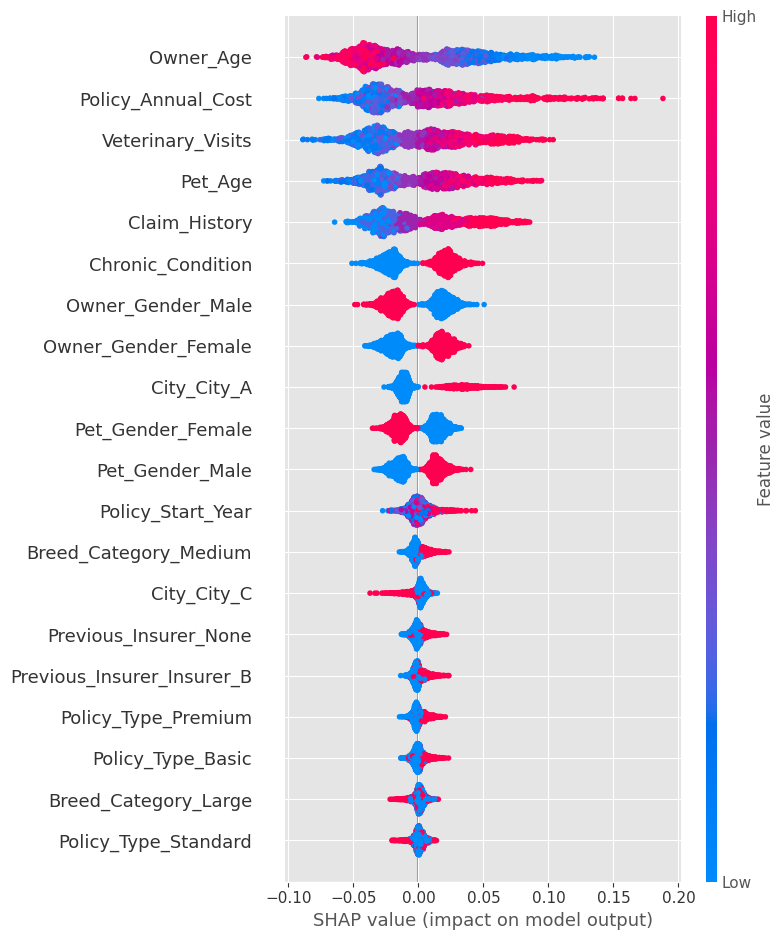

In [173]:
import shap

# Train RandomForest and calculate SHAP values
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# Visualize SHAP summary plot for overall feature importance
shap.summary_plot(shap_values[:, :, 1], X_test)